In [9]:
from google.colab import files

uploaded = files.upload()
video_path = list(uploaded.keys())[0]


Saving my_vid.mp4 to my_vid.mp4


In [2]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=80e12cdf804ac8e78915b36a426726e5630bb2f5e607053672ae783004a31cad
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


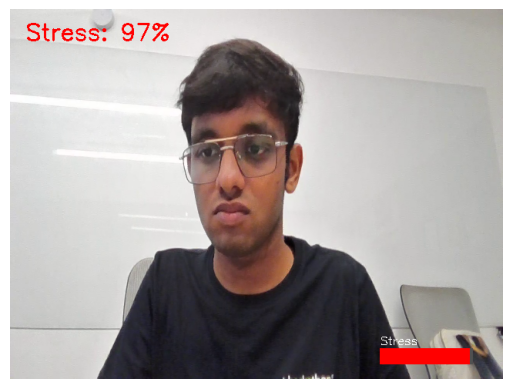

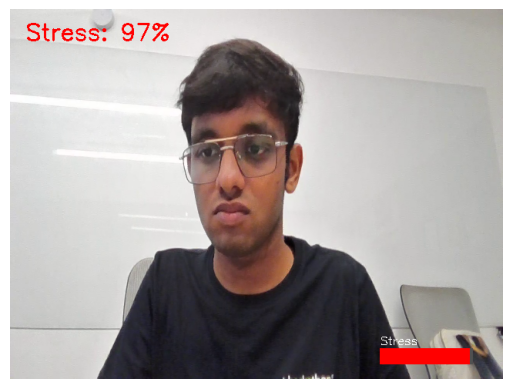

In [12]:
import cv2
from deepface import DeepFace
from collections import deque
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Emotion → stress weights
stress_weights = {
    'angry': 1.0,
    'fear': 1.0,
    'sad': 0.8,
    'disgust': 0.7,
    'surprise': 0.6,
    'neutral': 0.3,
    'happy': 0.0
}

# Initialize video capture
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 10

# Smoothing window
stress_history = deque(maxlen=8)  # moving average

frame_num = 0
frame_skip = 4  # faster while capturing enough frames

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_num += 1
    if frame_num % frame_skip != 0:
        continue

    # Resize for speed
    small = cv2.resize(frame, (640, 480))

    try:
        res = DeepFace.analyze(small, actions=['emotion'], enforce_detection=False)
        emotions = res[0]['emotion']
    except Exception:
        emotions = {}

    # Compute weighted stress score
    s = 0.0
    total_prob = sum(emotions.values()) or 100
    for emo, prob in emotions.items():
        w = stress_weights.get(emo, 0.0)
        s += (prob / total_prob) * w

    stress_history.append(s)
    smoothed = sum(stress_history) / len(stress_history)
    pct = int(smoothed * 100)

    # Annotate frame
    label = f"Stress: {pct}%"
    color = (0, 0, 255) if smoothed > 0.6 else (0, 255, 0)
    cv2.putText(small, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Draw moving stress bar
    h, w, _ = small.shape
    bx, by, bw, bh = w - 160, h - 40, 120, 20
    filled = int(bw * smoothed)
    cv2.rectangle(small, (bx, by), (bx + bw, by + bh), (80, 80, 80), -1)
    cv2.rectangle(small, (bx, by), (bx + filled, by + bh), color, -1)
    cv2.putText(small, 'Stress', (bx, by - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    # Display in notebook
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    display(plt.gcf())
